In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
from sklearn.neighbors import KNeighborsRegressor
from pathlib import Path

In [2]:
iterations = 101000
#SUBS_data_filename = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_SUBS_{iterations}.npy')
SUBS_data_filename = Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_SUBS_101000.npy')

X_subs = np.load(SUBS_data_filename).astype('float32')

In [3]:
kmax = 150
n = 90000

#LRES_data_filename = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n}_k_{kmax}.npy')
#Y_nwp = np.load(LRES_data_filename)

In [3]:
def generate_data(n, k, spinup, spacing, kmax=150, lres=False):
    N = iterations + 1
    # Regions
    fit_x, fit_y = slice(spinup, n + spinup - k), slice(spinup + k, n + spinup)
    prd_x, prd_y = slice(n + spinup, N - k), slice(n + spinup + k, N)

    # Data
    X_train, Y_train = X_subs[fit_x], X_subs[fit_y]
    X_test, Y_test = X_subs[prd_x], X_subs[prd_y]

    
    Y_lres = np.zeros_like(Y_test)
    if lres:
        if k>0:
            Y_lres = Y_nwp[k,spinup:-k,:]
        else:
            Y_lres = Y_nwp[k,spinup:,:]
        
    return X_train[::spacing], Y_train[::spacing], X_test[::spacing], Y_test[::spacing], Y_lres[::spacing]

# Fourier

In [4]:
from scipy.fftpack import fft2, ifft2, fftshift

In [5]:
iterations = 101000
HRES_data_filename = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_HRES_{iterations}.npz')
X_hres = np.load(HRES_data_filename)['sample'].astype('float32')
X_hres = np.array([X_hres[i].reshape((2**7+1,2**7+1)) for i in range(X_hres.shape[0])])

## 2D

In [6]:
def moving_average_2d_fft(time_series, window_size, stride):
    # Fourier transform along spatial dimensions for each time step
    fft_series = fftshift(fft2(time_series))
    times = []
    avg_fft = []
    
    t = 0
    while t + window_size < time_series.shape[0]:
        times.append(t)
        end_time = t + window_size
        avg_fft.append(np.average(np.abs(fft_series[t:end_time,:,:]),axis=0))
        t += stride
    return np.array(avg_fft), times

# Example usage
window_size = 10000
avg_fft, times = moving_average_2d_fft(X_hres, window_size, window_size)

In [7]:
global_min = np.inf
global_max = -np.inf

for i,res in enumerate(avg_fft):
    data = res
    global_min = min(global_min, np.min(data))
    global_max = max(global_max, np.max(data))

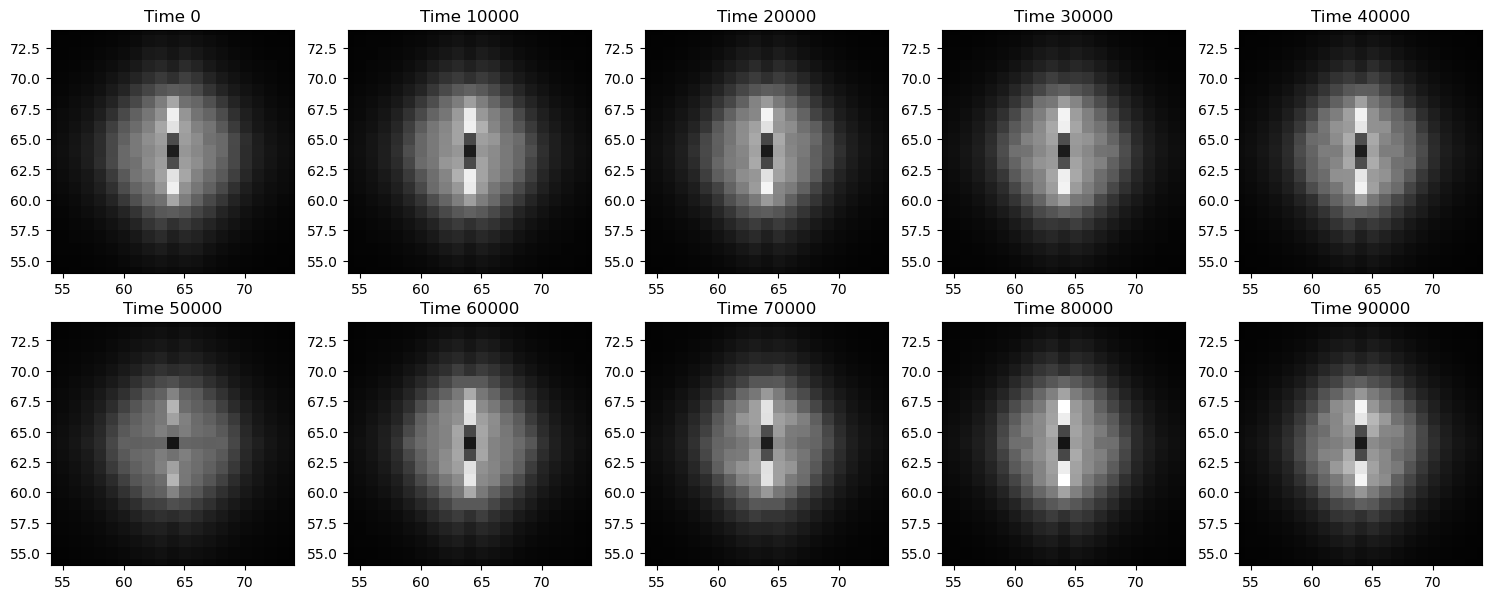

In [8]:
# Create a figure with subplots
yi, xi = 2,5
fig, axes = plt.subplots(yi, xi, figsize=(15, 6))  # Adjust the figsize as needed

delta = 10
# Loop over the first axis
for i, (res, t) in enumerate(zip(avg_fft, times)):
    row, col = i // xi, i % xi  # Determine the row and column for the subplot
    axes[row, col].imshow(res, cmap='gray', vmin=global_min, vmax=global_max)  # Plot the 2D slice
    axes[row, col].set_title(f'Time {t}')
    #axes[row, col].axis('off')
    axes[row, col].set_xlim([64-delta,64+delta])
    axes[row, col].set_ylim([64-delta,64+delta])

plt.tight_layout()
plt.show()

## Radial

In [9]:
# Compute the center of mass as the center of the 2D Fourier transform
center_x, center_y = 64, 64
max_size = center_x*2 + 1

# Create an array of radii
max_radius = min(center_x, center_y)  # Maximum radius is limited by the center position
radii = np.arange(0, max_radius)

# Initialize an array to store the radial profile
radial_profile = []

# Iterate over the radii
for i, r in enumerate(radii):
    # Create a binary mask of the circle with radius r centered at the origin
    y, x = np.ogrid[-center_y:max_size - center_y, -center_x:max_size - center_x]
    mask = (x**2 + y**2 <= (r+1)**2) & (x**2 + y**2 >= r**2)
    # Calculate the average magnitude within the circle
    radial_profile.append(mask)

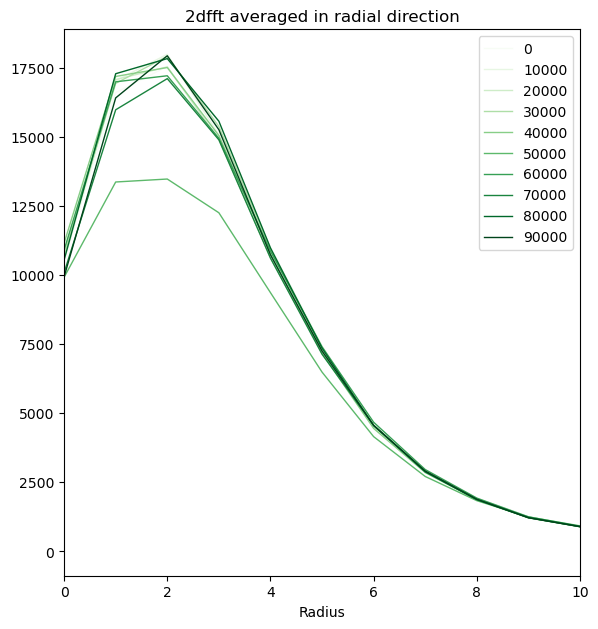

In [10]:
fig = plt.figure(figsize=(6,6))
from matplotlib.colors import LinearSegmentedColormap

colors = plt.cm.Greens(np.linspace(0, 1, len(avg_fft)))  # You can choose any colormap you like


# Loop over the first axis
for i, (res, t, color) in enumerate(zip(avg_fft, times, colors)):
    radial_res = np.array([np.mean(res[mask]) for mask in radial_profile])
    plt.plot(radii, radial_res, label=f'{t}', color=color, linewidth=1)

plt.legend()
plt.tight_layout()
plt.title("2dfft averaged in radial direction")
plt.xlim([0,10])
plt.xlabel("Radius")
plt.show()


# Forecast evaluation

In [5]:
def ensemble(n_ens, X_train, Y_train, X_test, Y_test, Y_lres):
    # Fit and Predict
    knn = KNeighborsRegressor(n_neighbors=n_ens, weights='distance')
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test).astype('float32')

    # Ensemble
    neigh_dist, neigh_ind = knn.kneighbors(X_test)
    ens_pred = Y_train[neigh_ind]

    # Sanity check
    inv_neigh_dist = 1 / neigh_dist
    ens_mean = np.sum(ens_pred*inv_neigh_dist[:,:,np.newaxis], axis=1)/np.sum(inv_neigh_dist, axis=1)[:,np.newaxis]
    print(np.linalg.norm(ens_mean - Y_pred))

    # Ensemble Spread
    # square root of average ensemble variance 

    # kNN
    ens_spread_knn = np.sqrt(np.mean(np.var(Y_pred[:,np.newaxis,:] - ens_pred, axis=1), axis=1))
    ens_rmse_knn = np.sqrt(np.mean((Y_pred - Y_test)**2, axis=1))
    #ens_bias = np.mean((Y_pred - Y_test), axis=1)

    # NWP
    ens_rmse_lres = np.sqrt(np.mean((Y_lres - Y_test)**2, axis=1))

    # Climatology
    Y_clm = np.mean(Y_test, axis=0)
    ens_spread_clm = np.std(Y_clm[np.newaxis,:] - Y_test, axis=1)
    ens_rmse_clm = np.sqrt(np.mean((np.mean(X_train, axis=0)[np.newaxis,:] - Y_test)**2, axis=1))

    # 
    return ens_spread_knn, ens_rmse_knn, ens_spread_clm, ens_rmse_clm, ens_rmse_lres

In [ ]:
k = 150
n = 90000
spinup = 1001
spacing = 10

X_train, Y_train, X_test, Y_test, Y_lres = generate_data(n, k, spinup, spacing)

n_ens = 100
ens_spread, ens_rmse, ens_spread_clm, ens_rmse_clm, ens_rmse_lres = ensemble(n_ens, X_train, Y_train, X_test, Y_test, Y_lres)

/tmp/ipykernel_7911/4126140844.py:1: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


0.00029546016894693115
0.0002607239827010949
0.00024451009255140065


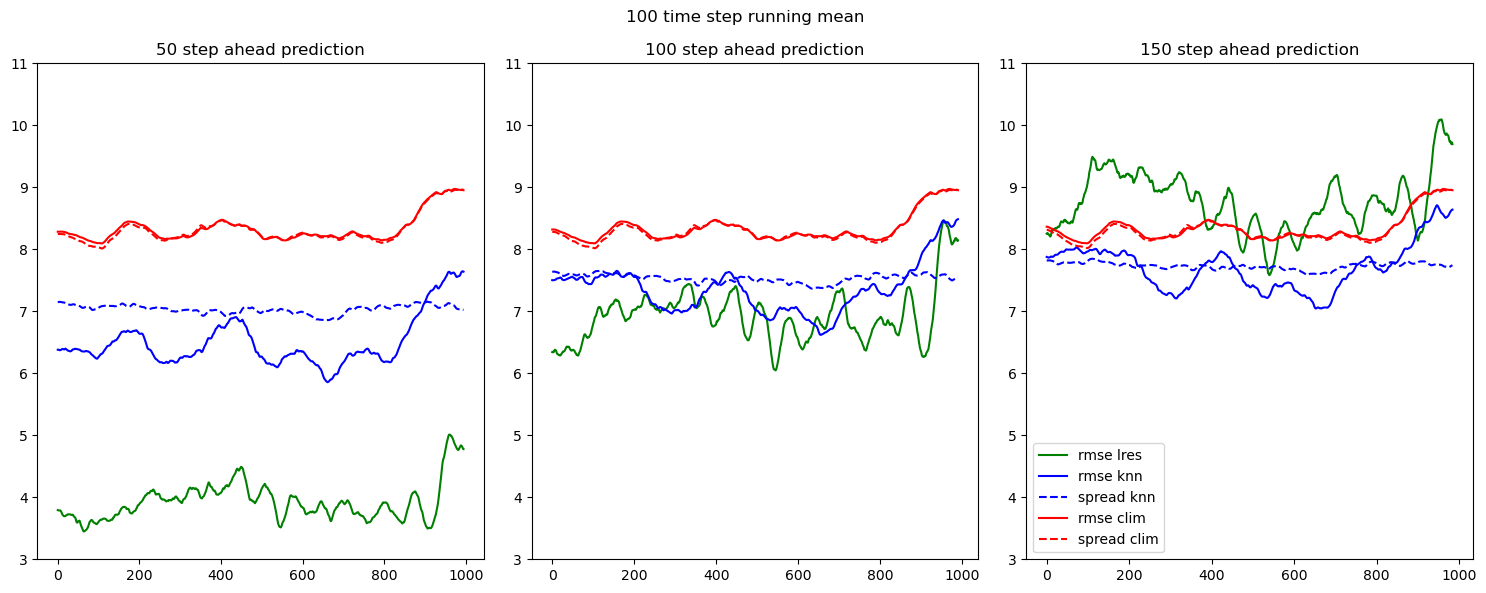

In [6]:
from scipy.ndimage.filters import uniform_filter1d
running_mean = 100
n = 90000
spinup = 1001
spacing = 10

ks = [50, 100, 150]
fig, axes = plt.subplots(1,3, figsize=(15, 6))  # Adjust the figsize as needed

for i, k in enumerate(ks):
    X_train, Y_train, X_test, Y_test, Y_lres = generate_data(n, k, spinup, spacing, lres=True)
    n_ens = 100
    ens_spread_knn, ens_rmse_knn, ens_spread_clm, ens_rmse_clm, ens_rmse_lres = ensemble(n_ens, X_train, Y_train, X_test, Y_test, Y_lres)

    axes[i].set_ylim(3, 11)
    axes[i].set_title(f'{k} step ahead prediction')
    axes[i].plot(uniform_filter1d(ens_rmse_lres, size=running_mean), 'g')
    axes[i].plot(uniform_filter1d(ens_rmse_knn, size=running_mean), 'b')
    axes[i].plot(uniform_filter1d(ens_spread_knn, size=running_mean), '--b')
    axes[i].plot(uniform_filter1d(ens_rmse_clm, size=running_mean),'r')
    axes[i].plot(uniform_filter1d(ens_spread_clm, size=running_mean), '--r')

plt.suptitle(f'{running_mean} time step running mean')
plt.legend(('rmse lres', 'rmse knn','spread knn','rmse clim','spread clim'))
plt.tight_layout()

# Latent space

In [4]:
k = 150
n = 90000
spinup = 1001
spacing = 10

X_train, Y_train, X_test, Y_test, Y_lres = generate_data(n, k, spinup, spacing)

mean_data = X_train.mean()
std_data = X_train.std()

X_train_normalized = (X_train - mean_data)/std_data

## PCA

In [5]:
from sklearn.decomposition import PCA

# Compute PCA
pca = PCA()
X_transformed = pca.fit_transform(X_train_normalized)

In [6]:
# Function to reconstruct data using first l components
def reconstruct_data(transformed_data, pca, l):
    return np.dot(transformed_data[:, :l], pca.components_[:l, :]) + pca.mean_

def reconstruction_error(original_data, reconstructed_data):
    return np.mean(np.square(original_data - reconstructed_data))

def plot_image(x):
    x = x.reshape((65,65))
    plt.imshow(x)


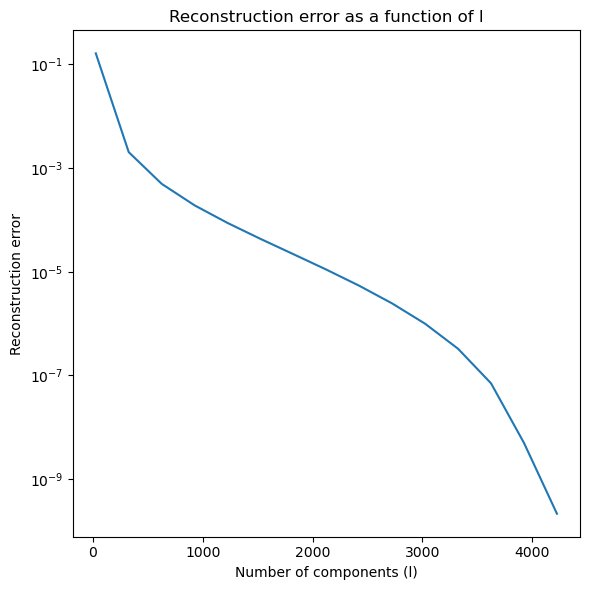

In [95]:
# Range of l values (number of components)
l_values = np.arange(25, 4226, 300) #100, 500, 1000, 2000, 3000, 4225] #range(1, min(X_train.shape) + 1)  # l ranges from 1 to s
errors = []

for l in l_values:
    reconstructed_data = reconstruct_data(X_transformed, pca, l)
    error = reconstruction_error(X_train_normalized, reconstructed_data)
    errors.append(error)

# Plotting the reconstruction errors

plt.figure(figsize=(6,6))
plt.semilogy(l_values, errors)
plt.xlabel('Number of components (l)')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error as a function of l')
plt.tight_layout()
plt.show()


0.0033202248


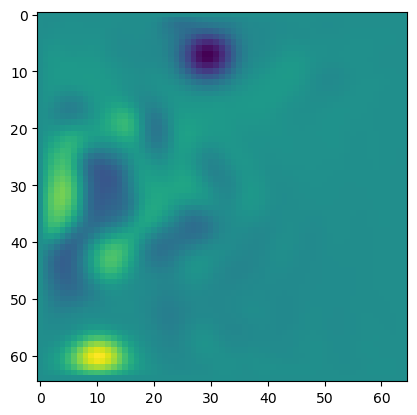

In [7]:
l = 256
X_PCA = reconstruct_data(X_transformed, pca, l)
error = reconstruction_error(X_train_normalized, X_PCA)
print(error)
plot_image(X_PCA[1000])

## Autoencoder

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [10]:
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)  # Convert to tensor

train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
batch_size = 64  # You can choose a batch size that fits your needs
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Linear

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(True),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(True),
            nn.Linear(hidden_size[1], hidden_size[2]),
            )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size[2], hidden_size[1]),
            nn.ReLU(True),
            nn.Linear(hidden_size[1], hidden_size[0]),
            nn.ReLU(True),
            nn.Linear(hidden_size[0], input_size),
            )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

Epoch [1/10], Average Loss: 0.3546
Epoch [2/10], Average Loss: 0.1384
Epoch [3/10], Average Loss: 0.0950
Epoch [4/10], Average Loss: 0.0776
Epoch [5/10], Average Loss: 0.0670
Epoch [6/10], Average Loss: 0.0605
Epoch [7/10], Average Loss: 0.0555
Epoch [8/10], Average Loss: 0.0530
Epoch [9/10], Average Loss: 0.0484
Epoch [10/10], Average Loss: 0.0473


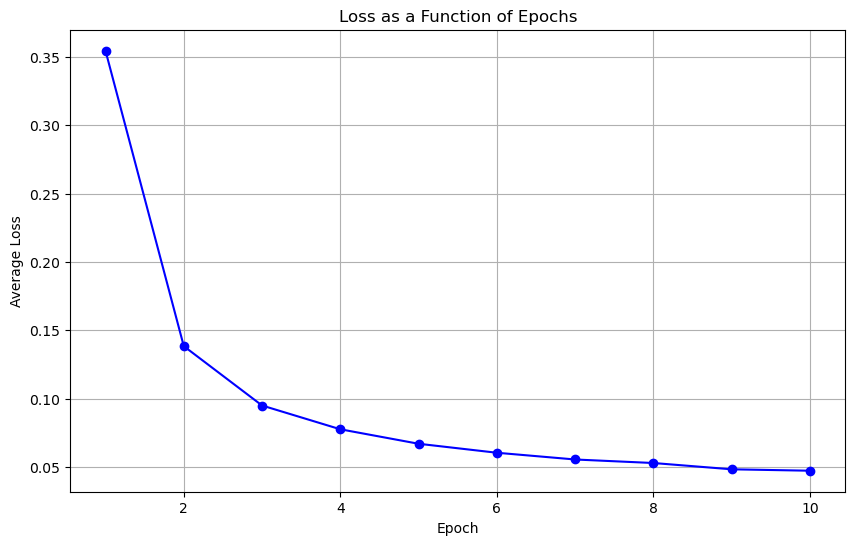

In [12]:
model = Autoencoder(input_size=4225, hidden_size=(500,200,100))  # Example sizes
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.apply(init_weights)

loss_values = []
num_epochs = 10
for epoch in range(num_epochs):
    total_loss=0
    for data in train_loader:
        img = data[0].to(device)  # Assuming the dataset returns a tuple (image, label)
        output = model(img)
        loss = criterion(output, img)
        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss = total_loss / len(train_loader)
    loss_values.append(total_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), [e.cpu().detach().numpy() for e in loss_values], marker='o', color='blue')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()


### Convolutional (U-net)

In [34]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.image_size = 65
        kernel_size = 3
        padding=1

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, padding=1),
            nn.Flatten(start_dim=2),
            )
        self.decoder = nn.Sequential(
            nn.Unflatten(2,(16, 16)),
            nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2), # 1
            )
        
    def forward(self, x):
        x = x.view(-1, 1, self.image_size, self.image_size)
        x = self.encoder(x)
        #print("Latent",x.shape)
        x = self.decoder(x)
        x = x.view(x.size(0),-1)
        return x

In [35]:
model = ConvAutoencoder()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#model.apply(init_weights)

err = []
num_epochs = 10
for epoch in range(num_epochs):
    total_loss=0
    for data in train_loader:
        img = data[0].to(device)  # Assuming the dataset returns a tuple (image, label)
        output = model(img)
        loss = criterion(output, img)
        total_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss = total_loss / len(train_loader)
    err.append(total_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {total_loss:.4f}')


Epoch [1/10], Average Loss: 0.7907
Epoch [2/10], Average Loss: 0.0248
Epoch [3/10], Average Loss: 0.0167
Epoch [4/10], Average Loss: 0.0139
Epoch [5/10], Average Loss: 0.0128
Epoch [6/10], Average Loss: 0.0119
Epoch [7/10], Average Loss: 0.0113
Epoch [8/10], Average Loss: 0.0107
Epoch [9/10], Average Loss: 0.0108
Epoch [10/10], Average Loss: 0.0107


## Evaluation

In [36]:
model.eval()

random_index = np.random.randint(len(X_train))
image_shape = (65, 65)  # Replace with the actual shape of your images

img_train = X_train_normalized[random_index].reshape(image_shape)
img_pca = X_PCA[random_index].reshape(image_shape)

X_AE = model(X_train_tensor[random_index].to(device).unsqueeze(0)).cpu().detach().numpy()
img_ae =  X_AE.reshape(image_shape)

X_enc = model.encoder(X_train_tensor[random_index].to(device).unsqueeze(0)).cpu().detach().numpy()
img_enc =  X_enc.reshape((16,16))

vmin = min(img_pca.min(), img_train.min(), img_ae.min())
vmax = max(img_pca.max(), img_train.max(), img_ae.max())


fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes[0,0].imshow(img_train, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')

axes[0,1].imshow(img_pca, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0,1].set_title(f'PCA Image')
axes[0,1].axis('off')

axes[0,2].imshow(img_ae, cmap='viridis', vmin=vmin, vmax=vmax)
axes[0,2].set_title(f'Autoencoder Image')
axes[0,2].axis('off')

axes[1,0].imshow(img_enc, cmap='viridis')
axes[1,0].set_title('Encoded Image')
axes[1,0].axis('off')

vmin_diff = min((img_pca-img_train).min(), (img_ae-img_train).min())
vmax_diff = max((img_pca-img_train).max(), (img_ae-img_train).max())

axes[1,1].imshow(img_pca- img_train, cmap='viridis', vmin=vmin_diff, vmax=vmax_diff)
er_PCA = np.round(reconstruction_error(img_train, img_pca),4)
axes[1,1].set_title(f'{str(er_PCA)}')
axes[1,1].axis('off')

axes[1,2].imshow(img_ae-img_train, cmap='viridis', vmin=vmin_diff, vmax=vmax_diff)
er_AE = np.round(reconstruction_error(img_train, img_ae), 4)
axes[1,2].set_title(f'{str(er_AE)}')
axes[1,2].axis('off')

plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 4225]